In [2]:
import json
import math
import torch


def load_scene(
    json_path: str,
    width: int,
    height: int,
    device: str = "cpu",
) -> tuple[list[str], torch.Tensor, torch.Tensor]:
    """
    Load camera intrinsics and camera-to-world extrinsics from a NeRF-style transforms JSON.

    Args:
        json_path: Path to the JSON file containing "camera_angle_x" and "frames".
        width: Render width in pixels.
        height: Render height in pixels.
        device: Torch device string (e.g. 'cpu' or 'cuda').

    Returns:
        file_paths: List of image file paths (as given in JSON).
        c2w_mats:   Tensor of shape (N,4,4), camera-to-world transforms.
        K:          Tensor of shape (3,3), camera intrinsics.
    """
    # 1. Read JSON
    with open(json_path, "r") as f:
        meta = json.load(f)

    # 2. Build intrinsics K from horizontal FOV
    camera_angle_x = meta["camera_angle_x"]
    focal = 0.5 * width / math.tan(0.5 * camera_angle_x)
    K = torch.tensor(
        [
            [focal,    0.0, width * 0.5],
            [   0.0, focal, height * 0.5],
            [   0.0,    0.0,        1.0],
        ],
        dtype=torch.float32,
        device=device,
    )

    # 3. Collect file paths and camera-to-world matrices
    file_paths: list[str] = []
    c2w_mats: list[torch.Tensor] = []

    for frame in meta["frames"]:
        file_paths.append(frame["file_path"])
        mat = torch.tensor(frame["transform_matrix"], dtype=torch.float32, device=device)
        c2w_mats.append(mat)

    # 4. Stack into (N,4,4)
    c2w_mats = torch.stack(c2w_mats, dim=0)

    return file_paths, c2w_mats, K

def rasterize_spheres(
    means: torch.Tensor,
    radii_world: float | torch.Tensor,
    viewmat: torch.Tensor,
    K: torch.Tensor,
    width: int,
    height: int,
) -> torch.Tensor:
    """
    Differentiable rasterizer for spheres of given world-space radius,
    rendered as Gaussian splats whose pixel-size varies with depth.

    Args:
        means:       (N,3) tensor of world-space sphere centers.
        radii_world: float or (N,) tensor of world-space sphere radii.
        viewmat:     (4,4) world->camera matrix.
        K:           (3,3) intrinsics matrix.
        width:       image width in pixels.
        height:      image height in pixels.

    Returns:
        (H,W,1) float32 tensor in [0,1]: black Gaussian spheres on white.
    """
    device, dtype = means.device, means.dtype
    N = means.shape[0]

    # -- ensure radii_world is a (N,) tensor on the right device/dtype
    if isinstance(radii_world, (float, int)):
        R_world = torch.full((N,), float(radii_world), device=device, dtype=dtype)
    else:
        R_world = radii_world.to(device=device, dtype=dtype)
        if R_world.ndim == 0:
            R_world = R_world.expand(N)
        elif R_world.numel() != N:
            raise ValueError(f"radii_world must be length-1 or length-{N}, got {R_world.shape}")

    # -- 1. World → camera space --
    ones   = torch.ones((N,1), device=device, dtype=dtype)
    homog  = torch.cat([means, ones], dim=1)                    # (N,4)
    cam_h  = (viewmat @ homog.T).T                             # (N,4)
    cam_pts= cam_h[:, :3] / cam_h[:, 3:4]                       # (N,3)
    z_cam  = cam_pts[:, 2]                                      # (N,)

    # -- 2. Compute per-sphere pixel radii: r_px = f * R_world / Z_cam --
    f      = K[0, 0]                                           # focal length in px
    r_px   = f * R_world / z_cam                               # (N,)

    # -- 3. Project to image plane --
    proj    = (K @ cam_pts.T).T                                # (N,3)
    means2D = proj[:, :2] / proj[:, 2:3]                       # (N,2)

    # -- 4. Build pixel grid --
    ys = torch.arange(height, device=device, dtype=dtype)
    xs = torch.arange(width,  device=device, dtype=dtype)
    yy, xx = torch.meshgrid(ys, xs, indexing='ij')              # (H,W)
    pix     = torch.stack([xx, yy], dim=-1).unsqueeze(2)        # (H,W,1,2)

    # -- 5. Build per-sphere inverse covariance --
    inv_var = 1.0 / (r_px**2)                                   # (N,)
    inv_cov = inv_var.view(1,1,N,1,1) * torch.eye(2, device=device, dtype=dtype).view(1,1,1,2,2)

    # -- 6. Mahalanobis distance --
    means2D_exp = means2D.view(1,1,N,2)                         # (1,1,N,2)
    diff        = pix - means2D_exp                             # (H,W,N,2)
    diff_u      = diff.unsqueeze(-1)                            # (H,W,N,2,1)
    m2          = (diff_u.transpose(-2,-1) @ inv_cov @ diff_u)  # (H,W,N,1,1)
    m2          = m2.squeeze(-1).squeeze(-1)                    # (H,W,N)

    # -- 7. Gaussian weights & composite alpha --
    w     = torch.exp(-0.5 * m2)                                # (H,W,N)
    alpha = 1 - torch.prod(1 - w + 1e-10, dim=2)                # (H,W)

    # -- 8. Black spheres on white bg --
    img   = alpha                                               # white minus alpha
    return img.unsqueeze(-1)                                    # (H,W,1)


import math
import torch
import torch.nn as nn

class BezierCurve(nn.Module):
    """
    Differentiable Bézier curve sampler producing Gaussian centers (means)
    and uniform thickness for each sample.
    """
    def __init__(
        self,
        init_control_points: torch.Tensor,
        thickness: float,
        overlap: float = 0.95,
        arc_samples: int = 200,
        device: str = 'cuda'
    ):
        super().__init__()
        # Control points as learnable parameters (N x 3)
        assert init_control_points.ndim == 2 and init_control_points.size(1) == 3
        self.P = nn.Parameter(init_control_points.to(device=device, dtype=torch.float32))
        self.thickness = float(thickness)
        self.overlap = float(overlap)
        self.arc_samples = int(arc_samples)
        self.device = device

        # Precompute dense parameter values t, and Bernstein coefficients
        t_dense = torch.linspace(0.0, 1.0, steps=self.arc_samples,
                                 device=device, dtype=torch.float32)
        self.register_buffer('t_dense', t_dense)

        N = self.P.size(0)
        binoms = torch.tensor([math.comb(N-1, k) for k in range(N)],
                              dtype=torch.float32, device=device)
        idxs = torch.arange(N, dtype=torch.float32, device=device)
        deg = torch.tensor(N-1, dtype=torch.float32, device=device)
        self.register_buffer('binoms', binoms)
        self.register_buffer('idxs', idxs)
        self.register_buffer('deg', deg)

    def _bezier_pts(self, t: torch.Tensor) -> torch.Tensor:
        """
        Compute Bézier points at parameters t (K x 1).
        Returns tensor of shape (K, 3).
        """
        # t: (K,1)
        t_pow = t ** self.idxs      # (K, N)
        one_pow = (1 - t) ** (self.deg - self.idxs)
        coefs = self.binoms * t_pow * one_pow  # (K, N)
        return coefs @ self.P                     # (K,3)

    def forward(self) -> (torch.Tensor, torch.Tensor):
        """
        Sample along the Bézier curve so that spheres of radius `thickness`
        overlap by `overlap` fraction.

        Returns:
            means: Tensor (M,3) of 3D sample points along curve.
            thicknesses: Tensor (M,) of uniform thickness values.
        """
        # 1. Sample dense points to approximate arc length
        pts = self._bezier_pts(self.t_dense.unsqueeze(1))   # (S,3)
        deltas = pts[1:] - pts[:-1]                         # (S-1,3)
        dists = deltas.norm(dim=1)                          # (S-1,)
        cumlen = torch.cat([torch.zeros(1, device=pts.device),
                            dists.cumsum(0)], dim=0)      # (S,)
        total_len = cumlen[-1].item()

        # 2. Determine number of samples M based on thickness and overlap
        diameter = 2.0 * self.thickness
        separation = diameter * (1.0 - self.overlap)
        M = max(1, int(math.ceil(total_len / separation)))

        # 3. Invert arc-length to get uniform spacing in parameter t
        s_des = torch.linspace(0.0, total_len, steps=M,
                               device=pts.device)
        idx = torch.bucketize(s_des, cumlen).clamp(1, self.arc_samples-1)
        c0, c1 = cumlen[idx-1], cumlen[idx]
        t0, t1 = self.t_dense[idx-1], self.t_dense[idx]
        t_samp = torch.lerp(t0, t1, (s_des - c0) / (c1 - c0))

        # 4. Compute final sample means and thickness vector
        means = self._bezier_pts(t_samp.unsqueeze(1))      # (M,3)
        thicknesses = torch.full((means.size(0),),
                                 self.thickness,
                                 dtype=means.dtype,
                                 device=means.device)
        return means, thicknesses


TypeError: unsupported operand type(s) for |: 'type' and 'torch._C._TensorMeta'

In [ ]:
# 1) load scene
image = 9
device = 'cuda'
W, H = 800, 800
file_paths, c2w_mats, K = load_scene("transforms_train.json", W, H, device=device)

# 2) pick center-of-scene camera (index 0 or whichever frames around center)
c2w = c2w_mats[image]                # camera-to-world
w2c = torch.linalg.inv(c2w)      # world-to-camera

# 3) instantiate Bezier curve around scene center
#    here control points in [-1,1]^3 space around the origin
init_pts = torch.tensor([
    [-1.0, 0.0, 0.0],
    [-0.5, 0.5, 0.2],
    [ 0.5,-0.5, 0.3],
    [ 1.0, 0.0, 0.0]
], dtype=torch.float32,device = 'cuda')
bez = BezierCurve(init_pts, thickness=0.05, overlap=0.9, arc_samples=300, device=device)

# 4) sample curve
means, thicknesses = bez()

# 5) render all spheres along the curve
img_t = rasterize_spheres(
    means=means,
    radii_world=thicknesses,
    viewmat=w2c,
    K=K,
    width=W,
    height=H
)  # (H,W,1)

# 6) convert & show
img_np = (img_t[...,0].cpu().detach().numpy()*255).astype("uint8")
img_pil = Image.fromarray(img_np, mode="L")
img_pil.show()


In [ ]:
img_pil

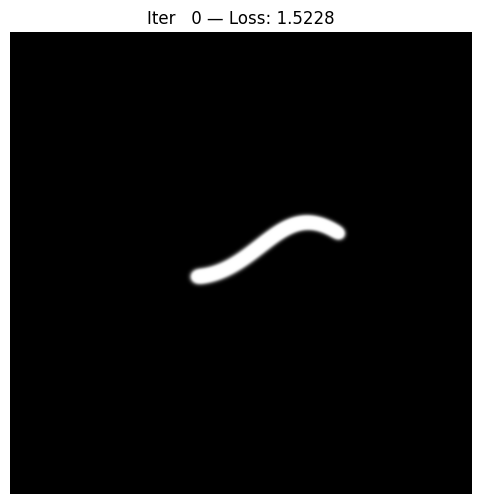

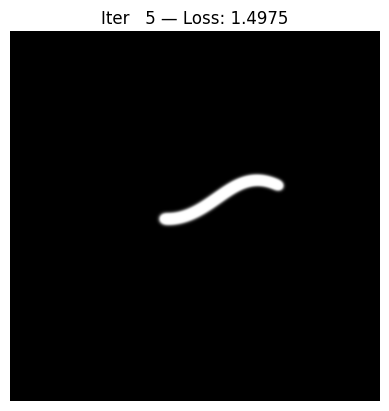

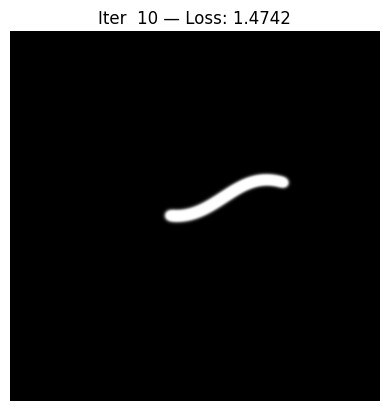

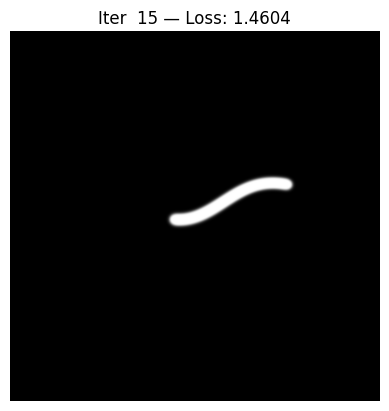

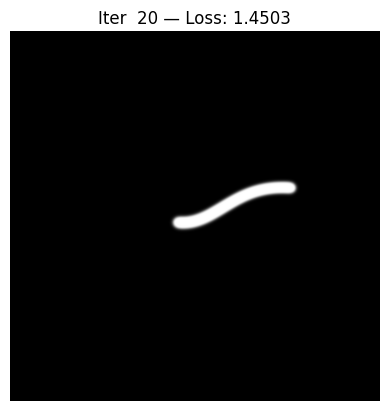

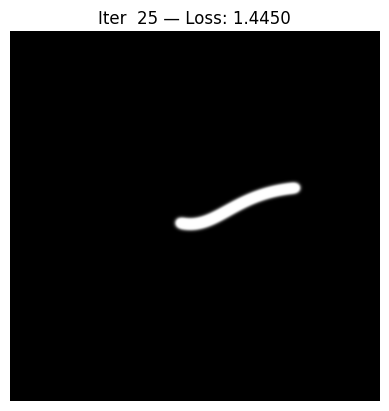

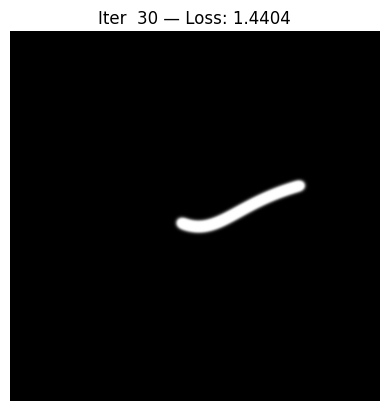

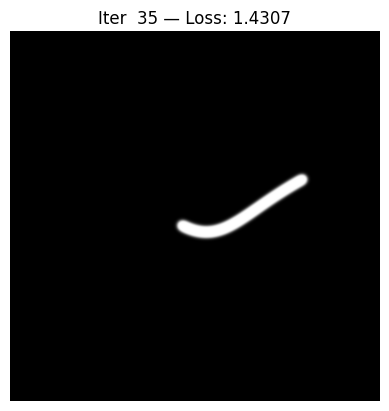

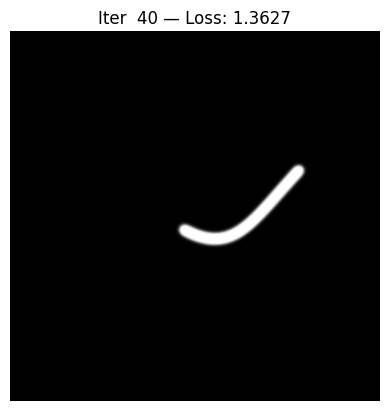

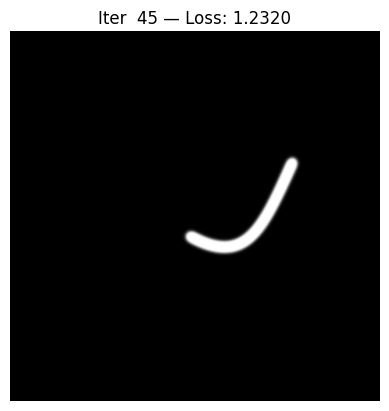

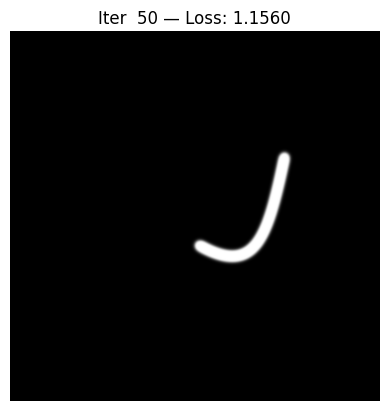

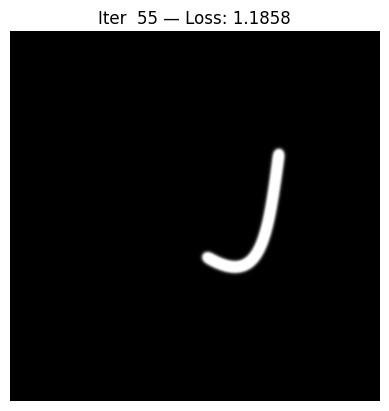

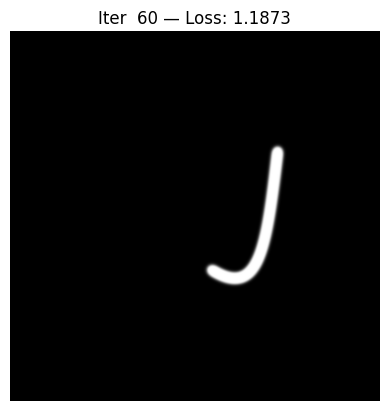

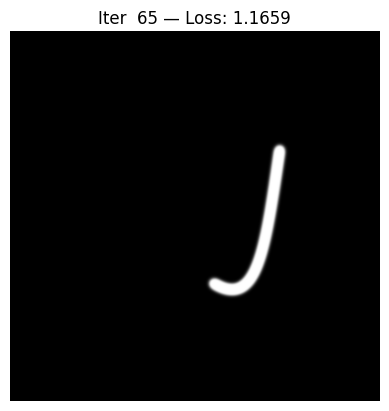

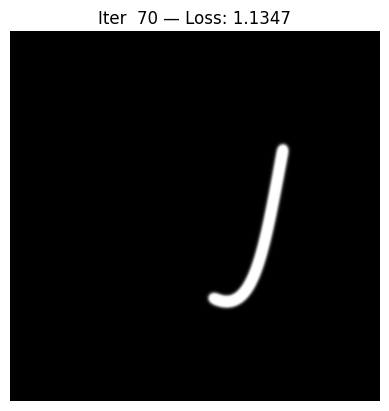

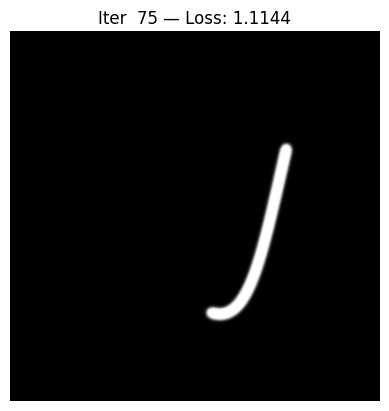

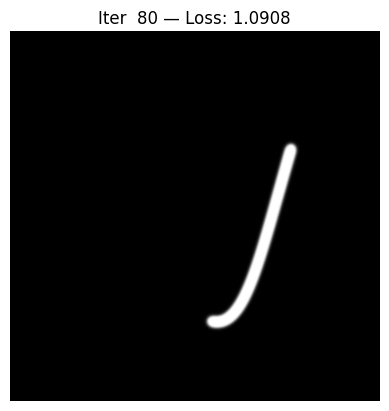

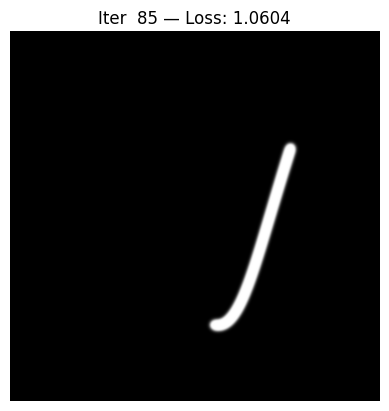

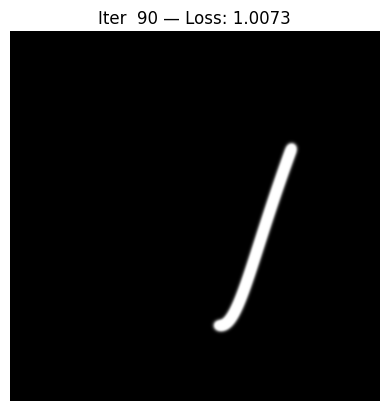

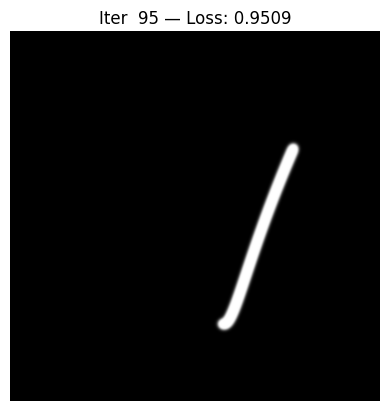

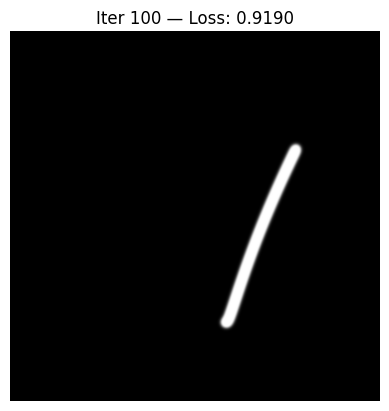

In [117]:
import json
import math
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as T

criterion = nn.BCELoss()

# Force CPU usage
device = 'cuda'
W, H = 800, 800

# Load scene for camera 0 (on CPU)
_, c2w_all, K = load_scene("transforms_train.json", W, H, device)
c2w0 = c2w_all[0]
w2c0 = torch.linalg.inv(c2w0)

# Load target image (on CPU)
to_tensor = T.ToTensor()
target = Image.open("test.jpeg").convert("L").resize((W,H))
target_t = to_tensor(target).to(device)  # (1,H,W)
target_t = 1 - target_t
target_t = (target_t > 0.5).float()
# Initialize Bezier curve (on CPU)
init_pts = torch.tensor([
    [-0.3, 0.0, 0.0],
    [0.0, 0.3, 0.2],
    [ 0.4,-0.3, 0.2],
    [ 0.7, 0.0, 0.0]
], device=device)
bez = BezierCurve(init_pts, thickness=0.02, overlap=0.9, arc_samples=300, device=device)

# Optimizer
opt = optim.Adam(bez.parameters(), lr=1e-2)

# Training loop with plotting every 5 iterations
import matplotlib.pyplot as plt
plt.ion()
fig = plt.figure(figsize=(6, 6))

for it in range(101):
    opt.zero_grad()

    means, th = bez()  # (M,3), (M,)
    img = rasterize_spheres(means, th, w2c0, K, W, H)  # (H,W,1)
    img = img.permute(2, 0, 1)  # -> (1,H,W)

    #loss = ((img - target_t)**2).mean()
    loss = criterion(img, target_t)
    loss.backward()
    opt.step()

    if it % 5 == 0:
        curr = img[0].detach().cpu().numpy()
        plt.clf()
        plt.imshow(curr, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Iter {it:3d} — Loss: {loss.item():.4f}")
        plt.axis('off')
        plt.pause(0.1)

plt.ioff()
plt.show()

In [123]:
import numpy as np
import plotly.graph_objects as go

# means_np: (M,3), thick_np: (M,)
# You should already have these from your notebook state.

fig = go.Figure()

# 1) Draw the Bézier curve as a line
fig.add_trace(go.Scatter3d(
    x=means_np[:, 0], y=means_np[:, 1], z=means_np[:, 2],
    mode='lines',
    line=dict(color='black', width=4),
    name='Bezier Curve'
))

# 2) Draw each sphere as a Mesh3d surface
u = np.linspace(0, 2*np.pi, 30)
v = np.linspace(0,   np.pi, 15)
u, v = np.meshgrid(u, v)

for (cx, cy, cz), r in zip(means_np, thick_np):
    # Parametric sphere
    x = cx + r * np.cos(u) * np.sin(v)
    y = cy + r * np.sin(u) * np.sin(v)
    z = cz + r * np.cos(v)

    fig.add_trace(go.Mesh3d(
        x=x.flatten(), y=y.flatten(), z=z.flatten(),
        alphahull=0,
        color='lightblue',
        opacity=0.6,
        name='Sphere',
        showscale=False
    ))

fig.update_layout(
    title="3D Visualization of Fitted Bézier-Curve Spheres",
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()